# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

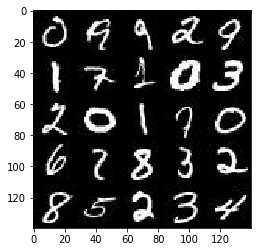

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

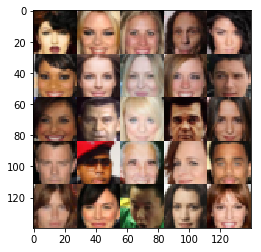

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [5]:
# train on aws gpu g3.8xlarge as generator() 5 layers is very slow

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    x = images
    alpha = 0.2
    drop = 0.8 # reviewer recommendation: add a dropout of 0.8 to avoid overfitting

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        # Leaky ReLU
        relu1 = tf.maximum(alpha * x1, x1)
        # dropout
        drop1 = tf.nn.dropout(relu1, drop)
        # 16x16x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # Leaky ReLU
        relu2 = tf.maximum(alpha * bn2, bn2)
        # dropout
        drop2 = tf.nn.dropout(relu2, drop)
        # 8x8x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        # Leaky ReLU
        relu3 = tf.maximum(alpha * bn3, bn3)
        # dropout
        drop3 = tf.nn.dropout(relu3, drop)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        # flat = tf.reshape(drop3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb

    reuse = not is_train
    alpha = 0.2
    drop = 0.5  
     
    # reviewer recommendations: 
    #   add one or two more layers
    #   config 7x7x512 to tf.layers.dense and reshape
    #   add a dropout of 0.5 in generator
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        # dropout
        x1 = tf.nn.dropout(x1, drop)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # Leaky ReLU
        x2 = tf.maximum(alpha * x2, x2)
        # dropout
        x2 = tf.nn.dropout(x2, drop)
        # 8x8x256 now
        
        ########## 
        # 5 layers - good faces generation needed 5 layers
        ##########
        # 1st extra layer
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # # Leaky ReLU
        x3 = tf.maximum(alpha * x3, x3)
        # # dropout
        x3 = tf.nn.dropout(x3, drop)
        # # 8x8x256 remain
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        # Leaky ReLU
        x4 = tf.maximum(alpha * x4, x4)
        # dropout
        x4 = tf.nn.dropout(x4, drop)
        # 16x16x128 now
        
        # 2nd extra layer
        x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        # Leaky ReLU
        x5 = tf.maximum(alpha * x5, x5)
        # dropout
        x5 = tf.nn.dropout(x5, drop)
        # 16x16x128 remain

        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now

#         ########## 
#         # 3 layers - numbers generation with 3 layers is enough, but not for faces
#         ##########
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         # Leaky ReLU
#         x3 = tf.maximum(alpha * x3, x3)
#         # dropout
#         x3 = tf.nn.dropout(x3, drop)
#         # 16x16x128 now
#         
#         # Output layer
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         # 32x32x3 now


        # resize to 28x28x3
        image_size_required = (28, 28)
        logits_right_size = tf.image.resize_images(logits, image_size_required)
        
        out = tf.tanh(logits_right_size)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    # 4.3 gan_mnist/Intro_to_GANs_Solution.ipynb - smooth
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # loop variables
    steps = 0    
    print_every = 10
    show_every = 100
    
    # real, fake, learning rate
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # input, learning rate
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    # loss                                
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # optimizer
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                          
                # reviewer recommendation: rescaling the batch_images from -0.5-0.5, to -1.0-1.0
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # batch_images is real images                
                # batch_z is fake images, random noise 
                
                # input_real is real input tensor - function parameter
                # input_z is fake input tensor - function parameter
                
                # Run optimizers                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     l_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     l_r: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    
                    n_images = 25 # batch_size
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 4.8039
Epoch 1/2... Discriminator Loss: 1.9792... Generator Loss: 3.5024
Epoch 1/2... Discriminator Loss: 1.9531... Generator Loss: 0.3062
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.6280
Epoch 1/2... Discriminator Loss: 2.3497... Generator Loss: 0.2657
Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.6358... Generator Loss: 0.4996
Epoch 1/2... Discriminator Loss: 1.6508... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.5815


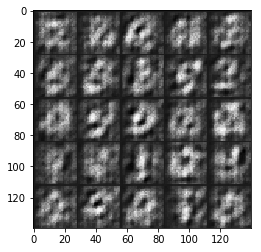

Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 1.4553
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 1.3154
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.9814
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 1.7916
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.5162


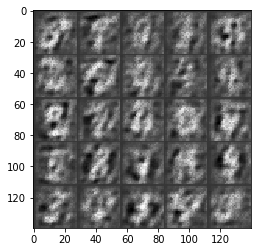

Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.8696
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 1.9590
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.7619


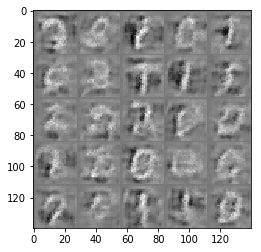

Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 1.5770
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 1.9563
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.0350
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 1.7634
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.5821


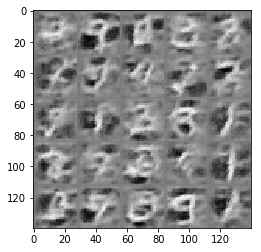

Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 1.5620
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 1.5470
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.8471


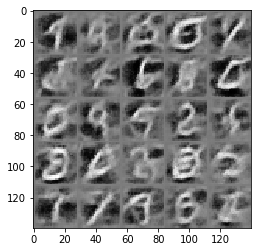

Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.7886
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.2901
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.8317


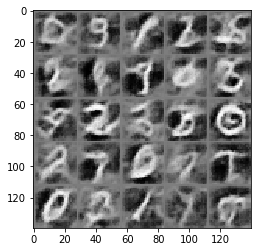

Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 1.5562
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 1.3352
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.7341
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.0497


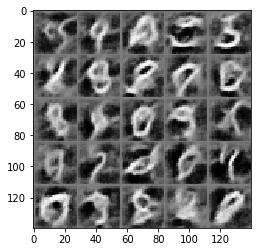

Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.4499
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 1.4859
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 1.2974
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.6900


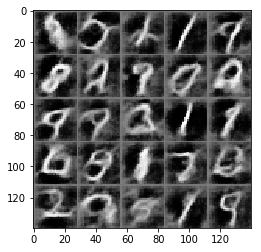

Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 2.3016
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.1702
Epoch 1/2... Discriminator Loss: 1.3892... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 0.8991


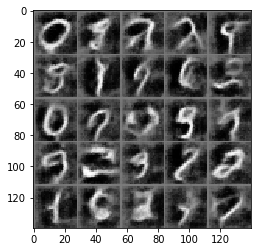

Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.7637


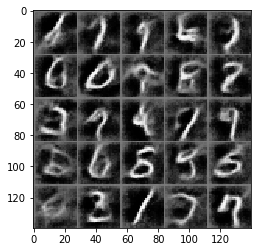

Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.4637
Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 1.8052
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 1.5370
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.0895


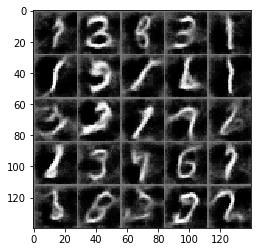

Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.5082
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 1.6047
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.8245
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.8282


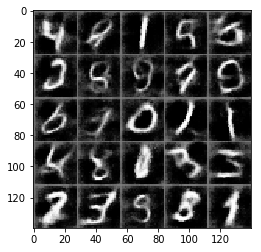

Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 1.5465
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.3478
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 1.8996
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.6686


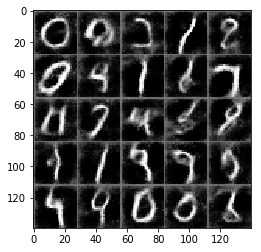

Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.3724


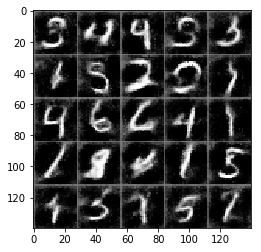

Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 1.4210
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.3348
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.3275


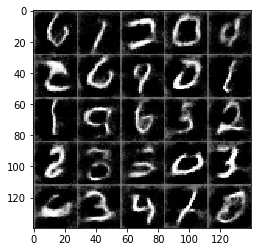

Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.5485


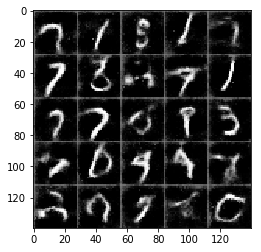

Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 0.9671... Generator Loss: 1.7594
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.4862
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 1.7657
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 1.4476
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.8238


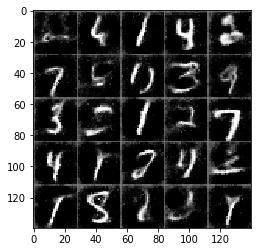

Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.5000
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 1.5818
Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 1.7386
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 0.8861


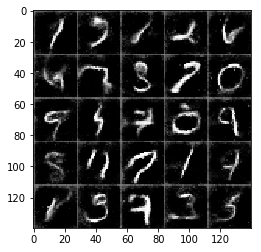

Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.2348
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 1.7387
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.1250
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 0.9711


In [46]:
# numbers train

batch_size = 64
z_dim = 200 # cannot apply 784 on 5 layers as resource exhaust error
learning_rate = 0.0005
beta1 = 0.3

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
# Some of the numbers generated can be recognised

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 10.5641
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 6.1413
Epoch 1/1... Discriminator Loss: 4.3483... Generator Loss: 15.2285
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 1.8274... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4519


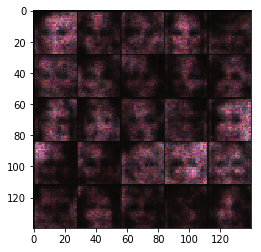

Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 2.1942... Generator Loss: 3.2145
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 2.2597... Generator Loss: 2.3130
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.1670


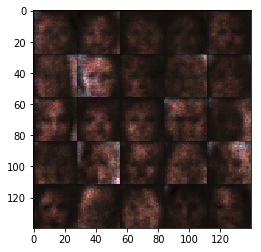

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 1.0241


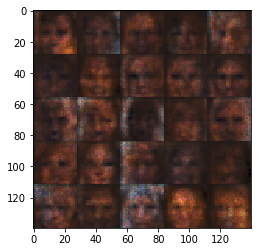

Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6910


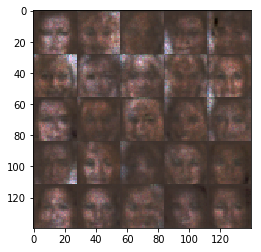

Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.5692


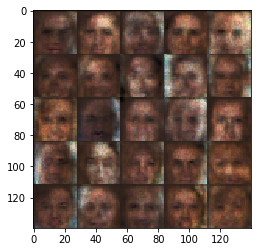

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9542


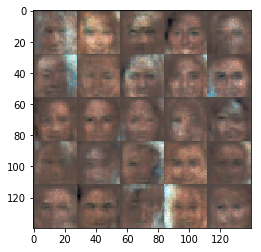

Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.1072


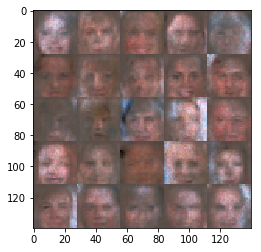

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7948


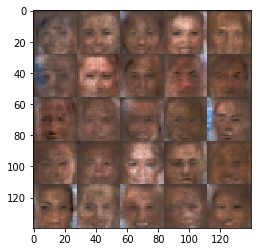

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 1.8273
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7502


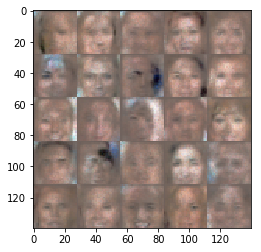

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8502


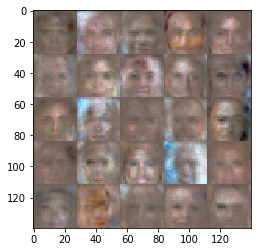

Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9993


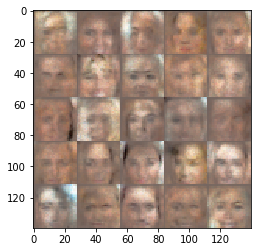

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8975


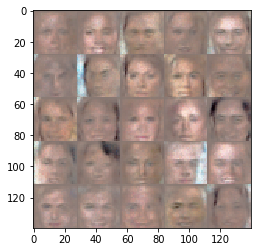

Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6346


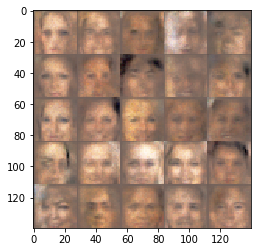

Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.2284


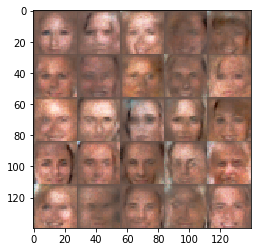

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8634


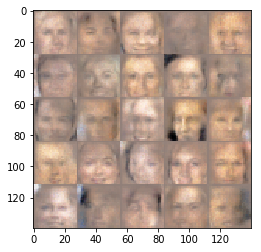

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 1.9219
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.2295


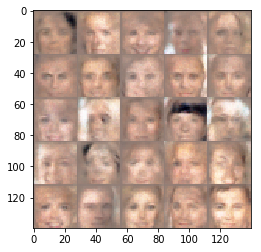

Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8352


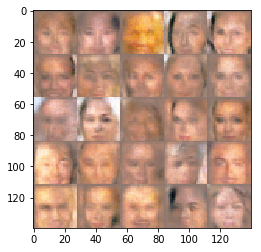

Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.5020


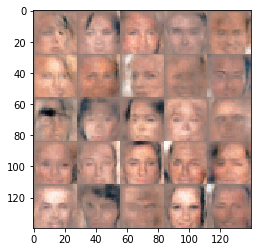

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 2.0348


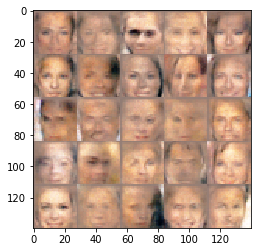

Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.8073... Generator Loss: 0.3166
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.2893


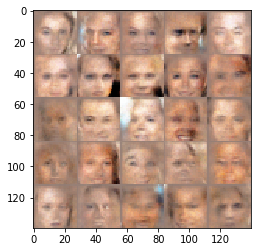

Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.9189


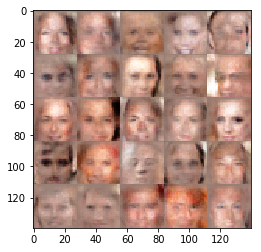

Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.3683


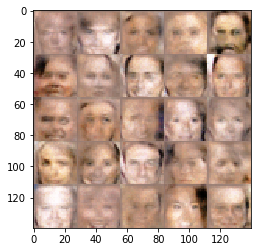

Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 1.0035


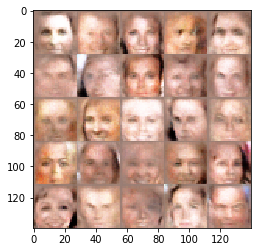

Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8328


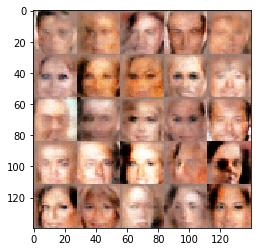

Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6633


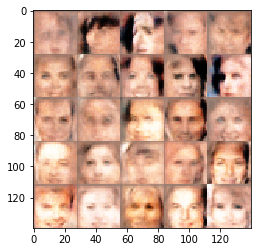

Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.6990


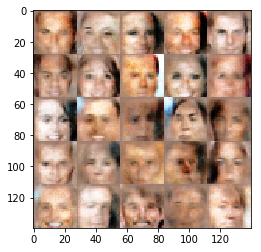

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8311


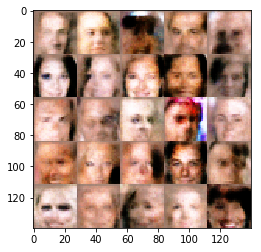

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6636


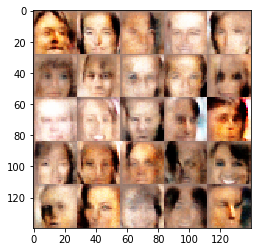

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7832


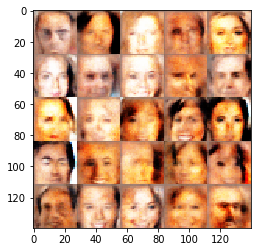

Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9242


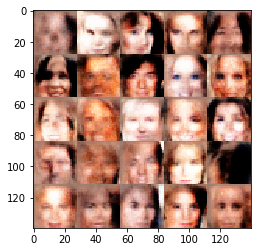

Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0850


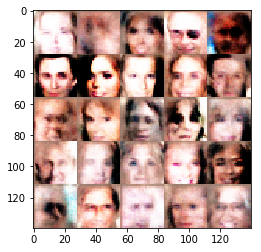

Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.4723
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 2.3907
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.3175


In [43]:
# face train

batch_size = 64
z_dim = 400 # cannot apply 784 on 5 layers as resource exhaust error
learning_rate = 0.0005
beta1 = 0.3

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
# A whole epoch is completed.
# The generated images are much better than i thought possible for this project.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.